## Analysis of GDP and Housing Prices
This file uses three datasets:

* US annual inflation data for 1995-2020(cite); this comes from two different sources:
    + [insert]
    + [insert]
* Zillow Home Value Indices (ZHVI) for 1996-2020
* US GPD by state

The intent of this analysis is to evaluate whether state GDP is a potential predictor of state housing prices, represented by ZHVI. ZHVI is adjusted for the following factors [insert]. The code follows the process described below:

* Import all data sets, covering data from 1995-present (as available)
* Clean and wrangle data as needed, including:
    + Convert GDP values from string to numeric, including removing commas. 
* Create a dataframe with ZHVI and GDP data, joining on year. Includes the following steps
    + Change ZHVI date formats to allow for DateTime functions
    + Trim ZHVI data to only Virginia
    + Transpose ZHVI data using the melt function - changing data structure from wide to long
    + Convert ZHVI values from string to numeric
    + Create month and year periods for grouping
    + Perform a groupby to condense ZHVI values to a single mean value per year
* Calculate annual cumulative inflation factors to allow for adjustment of any year (within range 1996 to 2020) to 2019 dollars
    + Use map() function to put inflation factors in a dictionary for use in a flexible function.
* Calculate inflation-adjusted GDP and ZHVI, using 2019 dollars as the base currency period
    + Write a function that will take any dataframe with 'value' and 'dollar-yr' columns and generate a column with values adjusted to 2019 dollars. 
    + Run the inflation adjustment function on Virginia GDP data.
    + Run the inflation adjustment function on Virginia home price data.
* Join the results into a dataframe on year
    + Rename several columns to avoid redundancy (that existed so function could run on both dataframes).
* Plot inflation-adjusted GDP and ZHVI and inspect the relationship visually
* Run a single linear regression (SLR) model for inflation-adjusted GDP and ZHVI for the relevant time period. 

### To-Do
* Review confidence interval approach
* Write unit tests on the inflation adjustment method

Optional:

* Conduct a similar analysis for one or more states
* Further analysis?

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from os import *
import matplotlib.pyplot as plt
import matplotlib as mpl

###
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt


In [2]:
# Read in the inflation data from '1995inflation.csv'
inf_data = pd.read_csv("../dataset/1995inflation.csv")
inf_data.tail()

,year,amount,inflation rate,cumulative
21,2016,1.57,0.0126,0.5748
22,2017,1.61,0.0213,0.6084
23,2018,1.65,0.0249,0.6485
24,2019,1.68,0.0176,0.6775
25,2020,1.71,0.0181,0.7079


In [3]:
# Read in the GDP data
gdp_data = pd.read_csv("../dataset/yearlyGDPbyState.csv")

# Check data types
gdp_data.dtypes

# GDP is not numeric, convert it to numeric
# First remove the commas in the strings 
#gdp_data['GDP']=gdp_data['GDP'].str.replace(',','')

# Make numeric
gdp_data['GDP']= pd.to_numeric(gdp_data['GDP'], errors = 'coerce')
# rename the year column for function use
gdp_data = gdp_data.rename(columns = {'year':'yr'})

# Check the datatypes
gdp_data.dtypes

Unnamed: 0           int64
yr                   int64
state               object
current dollars      int64
GDP                float64
GDP_area            object
dtype: object

In [4]:
# Read in the housing price data
zhvi = pd.read_csv("../dataset/zillow_HVI_1996-2020.csv")

# Cut the df down to only Virginia values
zhvi_va = zhvi[zhvi['RegionName']=="Virginia"]

# Turn data from wide to long for easier manipulation, using melt() function
zhvi_va_days = zhvi_va.melt(id_vars=['RegionID','RegionName', 'RegionType'], var_name='DD-MM-YYYY')

# Drop first two columns of resulting DF, which are not numeric
zhvi_va_days.drop([0,1], inplace=True)

# Replace '/' with '-' for use of datetime functions 
zhvi_va_days['DD-MM-YYYY'] = zhvi_va_days['DD-MM-YYYY'].str.replace("/","-")

# Convert index values from string to numeric
zhvi_va_days['value'] = pd.to_numeric(zhvi_va_days['value'])

# check the output
zhvi_va_days.tail()

,RegionID,RegionName,RegionType,DD-MM-YYYY,value
293,56,Virginia,State,4-30-2020,291177.0
294,56,Virginia,State,5-31-2020,292430.0
295,56,Virginia,State,6-30-2020,293816.0
296,56,Virginia,State,7-31-2020,295301.0
297,56,Virginia,State,8-31-2020,296848.0


In [5]:
# Create columns for year and month
# Year
zhvi_va_days['yr'] = pd.DatetimeIndex(zhvi_va_days['DD-MM-YYYY'], dayfirst=True).year
# Month
zhvi_va_days['period'] = pd.DatetimeIndex(zhvi_va_days['DD-MM-YYYY'], dayfirst = True).month

zhvi_va_days.dtypes

RegionID        int64
RegionName     object
RegionType     object
DD-MM-YYYY     object
value         float64
yr              int64
period          int64
dtype: object

In [6]:
# Use Groupby to get mean values per year
zhvi_va_year = zhvi_va_days.groupby(by =['yr'], as_index = False).mean()

# Round the values
zhvi_va_year['value'] = round(zhvi_va_year['value'],2)

# add a 'dollar year' column for use in the function. For this dataset, dollars are reported in same year
zhvi_va_year['dollar-yr'] = zhvi_va_year['yr'] 


zhvi_va_year.head()

,yr,RegionID,value,period,dollar-yr
0,1996,56.0,120939.50,6.5,1996
1,1997,56.0,122214.83,6.5,1997
2,1998,56.0,125167.08,6.5,1998
3,1999,56.0,129912.08,6.5,1999
4,2000,56.0,138695.08,6.5,2000


In [7]:
# Work with the inflation data to use in an adjustment function

# Column'amount' is a cumulative price index with 1995 as year 0. 
# Calculate a factor for each state that converts 'amount' to 2019 dollars by dividing by 1.68 (the 2019 'amount'value)

# Select the conversion factor from the data frame using .loc
d2019 = inf_data.loc[inf_data['year'] == 2019,'amount'].item()
print(d2019)

# Apply the factor to all rows
inf_data['2019_factor']=inf_data['amount']/d2019
inf_data.head()

1.68


,year,amount,inflation rate,cumulative,2019_factor
0,1995,1.00,0.0000,0.0000,0.595238
1,1996,1.03,0.0295,0.0295,0.613095
2,1997,1.05,0.0229,0.0531,0.625000
3,1998,1.07,0.0156,0.0696,0.636905
4,1999,1.09,0.0221,0.0932,0.648810


In [8]:
# Store the factors in a dictionary for easy use in a function
inf_dict_2019 = dict(zip(inf_data['year'], inf_data['2019_factor']))
inf_dict_2019[1995] # Testing calling a single value

0.5952380952380952

In [9]:
# Create a function that adjusts a series of data based on 2019_factor. The function accepts a dataframe and a dictionary of 
# inflation factor, which must have a column labeled 'dollar-yr' and a column labeled 'value'. 

# Function to convert a column labeled 'value', from the passed dataframe to 2019 dollars
# Years can be from anywhere in the range of 1996-2020 
    
def inflation_adjust_to2019(df, price_dict): 
    #Create a new column that takes the dollar value column and divides each value by the appropriate inflation amount. The
    # inflation factor is pulled from the called dictionary based on the column 'dollar-yr' value.
    df['inf-adjusted'] = round(df['value']/df['dollar-yr'].map(price_dict))
    
    return df

In [10]:
# Create a Virginia GDP dataframe to pass through the function
va_gdp = gdp_data[gdp_data['state']=='Virginia']

# Rename the column so it works with the function
va_gdp_toFunc = va_gdp.rename(columns={'GDP':'value', 'current dollars':'dollar-yr'})

# Drop unnecessary columns
va_gdp_toFunc = va_gdp_toFunc.drop(columns=['GDP_area', 'Unnamed: 0'])

va_gdp_toFunc.tail()

,yr,state,dollar-yr,value
1066,2015,Virginia,2016,484962.333333
1117,2016,Virginia,2016,494349.000000
1168,2017,Virginia,2018,510424.750000
1219,2018,Virginia,2018,534448.750000
1270,2019,Virginia,2019,554211.250000


In [11]:
# Run the inflation adjustment function on the Virginia GDP dataframe and assign to a dataframe
adjusted_va_gdp = inflation_adjust_to2019(va_gdp_toFunc,inf_dict_2019)

# Rename columns to avoid redundant names, reset index
adjusted_va_gdp = adjusted_va_gdp.reset_index(drop = True).rename(columns = {'value':'GDP', 'inf-adjusted':'GDP-2019-Dollars', 'dollar-yr':'gdp-dollar-yr'})
adjusted_va_gdp.head()

,yr,state,gdp-dollar-yr,GDP,GDP-2019-Dollars
0,1995,Virginia,2001,188963.0,273671.0
1,1996,Virginia,2001,199953.0,289587.0
2,1997,Virginia,2001,212105.0,307187.0
3,1998,Virginia,2001,228049.0,330278.0
4,1999,Virginia,2001,241503.0,349763.0


In [12]:
# Run the inflation adjustment function on the Zillow values and assign to a dataframe
adjusted_zhvi = inflation_adjust_to2019(zhvi_va_year,inf_dict_2019)

# Rename columns to avoid redundant names
adjusted_zhvi = adjusted_zhvi.reset_index(drop = True).rename(columns = {'value':'ZHVI', 'inf-adjusted':'ZHVI-2019-Dollars', 'dollar-yr':'zhvi-dollar-yr'})\
.drop(columns = 'period')
adjusted_zhvi.tail()

,yr,RegionID,ZHVI,zhvi-dollar-yr,ZHVI-2019-Dollars
20,2016,56.0,254193.67,2016,272003.0
21,2017,56.0,263480.50,2017,274936.0
22,2018,56.0,272584.25,2018,277540.0
23,2019,56.0,282955.25,2019,282955.0
24,2020,56.0,292155.12,2020,287030.0


In [13]:
#Complete an inner join on 'year' with the GDP data (left) and housing data (right).
gdp_zhvi_data=adjusted_va_gdp.merge(adjusted_zhvi, on='yr', left_index=True)

gdp_zhvi_data.dtypes

yr                     int64
state                 object
gdp-dollar-yr          int64
GDP                  float64
GDP-2019-Dollars     float64
RegionID             float64
ZHVI                 float64
zhvi-dollar-yr         int64
ZHVI-2019-Dollars    float64
dtype: object

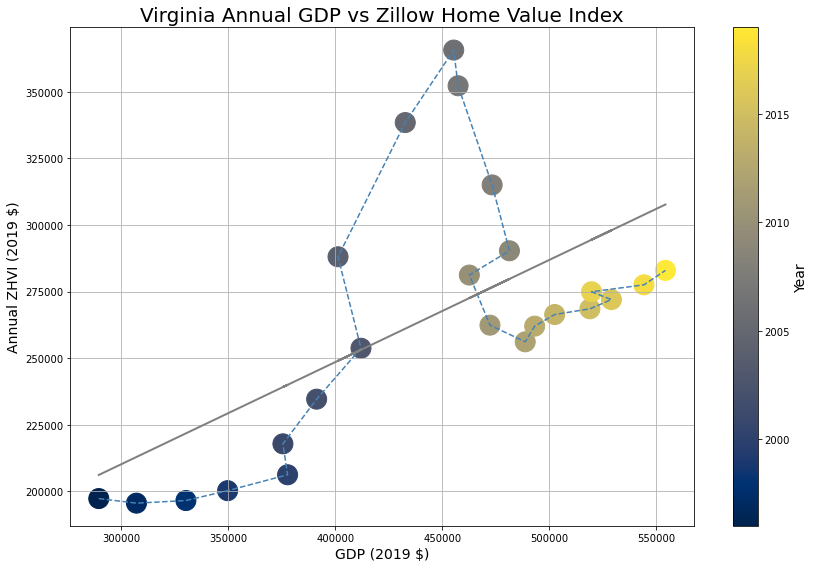

In [14]:
# Create a visualization of GDP and ZHVI

# Only a single plot - using this as a best practice for later reflection 
fig, ax = plt.subplots()  # Create a figure and an axes.

# Setup colors by year
color_years = gdp_zhvi_data['yr']

# Call the variables for plotting, including assigning years to color
ax.scatter(gdp_zhvi_data['GDP-2019-Dollars'],gdp_zhvi_data['ZHVI-2019-Dollars'], c=color_years, s = 400, cmap = 'cividis') 

# Label the graph
ax.set_xlabel('GDP (2019 $)', fontsize = 14)  # Add an x-label to the axes.
ax.set_ylabel('Annual ZHVI (2019 $)',fontsize = 14)  # Add a y-label to the axes.
ax.set_title("Virginia Annual GDP vs Zillow Home Value Index",fontsize = 20)  # Add a title to the axes.

# Aesthetic mods
ax.grid(True) # Add a grid
fig.set_size_inches(12, 8) # Set fixed size

# Setup a colorbar to see the gradient
# call the color map to use ('cividis') via matplotliv
cmap = mpl.cm.cividis
# Set the scale to match the data
norm = mpl.colors.Normalize(vmin=color_years.min(), vmax=color_years.max())
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='Year')

# Add a dashed line that shows the progression of time 
ax.plot(gdp_zhvi_data['GDP-2019-Dollars'],gdp_zhvi_data['ZHVI-2019-Dollars'], label='linear', linestyle = 'dashed', color = 'steelblue')
# Change the font size of the label
cb.set_label(label='Year', fontsize = 14)

# Simple polyfit regression


#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(gdp_zhvi_data['GDP-2019-Dollars'],gdp_zhvi_data['ZHVI-2019-Dollars'], 1)

#add linear regression line to scatterplot 
plt.plot(gdp_zhvi_data['GDP-2019-Dollars'], m*gdp_zhvi_data['GDP-2019-Dollars']+b, color = 'grey', linewidth=2.0)

# automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()

plt.show()

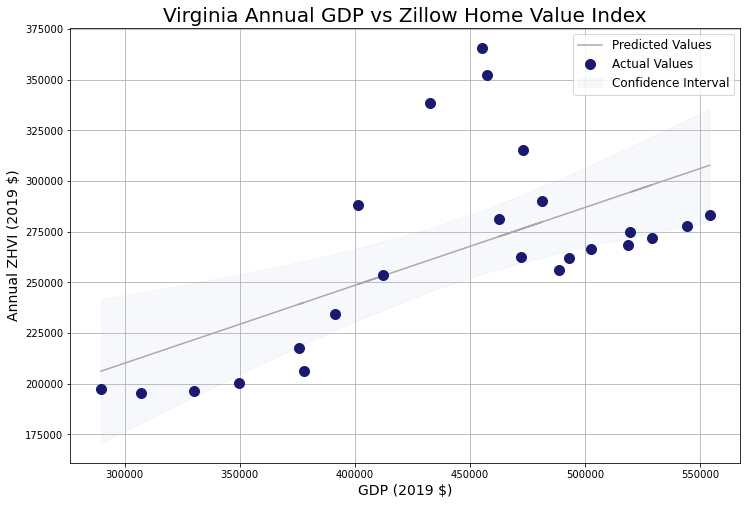

In [15]:
# Simple polyfit regression to plot confidence intervals. Excluded coloring the years - focus is on goodness of fit of
# the predictor (GDP) and response (ZHVI)

# I used the Matplotlib documentation found here: 
# https://matplotlib.org/3.1.3/gallery/lines_bars_and_markers/fill_between_demo.html#sphx-glr-gallery-lines-bars-and-markers-fill-between-demo-py
va_gdp = gdp_zhvi_data['GDP-2019-Dollars']
va_zhvi = gdp_zhvi_data['ZHVI-2019-Dollars']


# Obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(va_gdp, va_zhvi, deg=1)

# Set the estimated equation for 
va_zhvi_est = m * va_gdp + b

# Calculate the error terms - NEED TO CHECK THIS CALCULATION... APPROACH MAY BE OFF
va_zhvi_err = va_gdp.std() * np.sqrt(1/len(va_gdp) +
                          (va_gdp - va_gdp.mean())**2 / np.sum((va_gdp - va_gdp.mean())**2))

# Setup a confidence interval plot
figCI, axCI = plt.subplots()
axCI.plot(va_gdp, va_zhvi_est, '-', color = 'darkgrey', label = 'Predicted Values')
# Set confidence interval bars
axCI.fill_between(va_gdp, va_zhvi_est - va_zhvi_err, va_zhvi_est + va_zhvi_err, color = 'lightsteelblue', alpha=0.1, label = 'Confidence Interval')
axCI.plot(va_gdp, va_zhvi, 'o', color='midnightblue', markersize = 10, label = 'Actual Values')

# Label the graph
axCI.set_xlabel('GDP (2019 $)', fontsize = 14)  # Add an x-label to the axes.
axCI.set_ylabel('Annual ZHVI (2019 $)',fontsize = 14)  # Add a y-label to the axes.
axCI.set_title("Virginia Annual GDP vs Zillow Home Value Index",fontsize = 20)  # Add a title to the axes.
axCI.grid(True) # Add a grid
figCI.set_size_inches(12, 8) # Set fixed size
plt.legend(fontsize = 12)

plt.show()